In [1]:
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares

In [2]:
parent = r'C:/Users/ricca/QTLab2324/IRdetection/Instruments/Test_data/data_20_02_set1'

In [3]:
def reader(parent):

    data = {
        "res1" : [],
        "res2" : [],
        "res3" : [],
        "res4" : []
    }

    for folder in os.listdir(parent):
        if folder.startswith("T"):
            T = folder.replace('T_','')
            for file in os.listdir(parent + '/' + folder):
                dic = {
                    'F' : [],
                    'I' : [],
                    'Q' : [],
                    'S21' : []
                }
                with h5py.File(parent + '/' + folder + '/' + file, 'r') as f:
                    dic['F'] = np.array(f['raw_data']['f'][:])
                    dic['I'] = np.array(f['raw_data']['i'][:])
                    dic['Q'] = np.array(f['raw_data']['q'][:])
                    dic['S21'] = 20*np.log(np.sqrt(dic['I']**2 + dic['Q']**2))
                    dic['Phi'] = np.unwrap(np.arctan2(dic['I'],dic['Q']))
                    if '1' in file:
                        data['res1'].append([T, dic])
                    elif '2' in file:
                        data['res2'].append([T, dic])
                    elif '3' in file:
                        data['res3'].append([T, dic])
                    elif '4' in file:
                        data['res4'].append([T, dic])
    
    return data 

In [4]:
def resonance_model(x,a, Q, Qc,phi0):
    return -a*np.abs(1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q))))

def model(x, a0, a1, a2, Q, Qc,phi0):
    params = np.array([a0,a1,a2])
    pol = np.polyval(params, x)
    res = resonance_model(x, a0, Q,Qc,phi0)
    return res*pol

In [5]:
data = reader(parent)

In [6]:
F, T, S21, Phi, I, Q = [], [], [], [],[], []
   
for i,datas in enumerate(data['res2']):
    T.append(int(datas[0]))
    S21.append(datas[1]['S21'])
    F.append(datas[1]['F'])
    Phi.append(datas[1]['Phi'])

In [7]:
sorted_indices = sorted(range(len(T)), key=lambda k: T[k])
T   = [np.array(T[i]) for i in sorted_indices]
S21 = [np.array(S21[i]) for i in sorted_indices]
Phi = [np.array(Phi[i]) for i in sorted_indices]
F   = [np.array(F[i]) for i in sorted_indices]

Center data around resonance minimum

In [8]:
a = []
for i in range(len(T)):
    a.append(np.polyfit(F[i],Phi[i],1))
    Phi[i] = Phi[i] - np.polyval(a[i],F[i])
    F[i] = (F[i]-F[i][np.argmin(S21[i])])/F[i][np.argmin(S21[i])]
    F[i] = F[i][(np.argmin(S21[i])-50):(np.argmin(S21[i])+50)]
    Phi[i] = Phi[i][(np.argmin(S21[i])-50):(np.argmin(S21[i])+50)]

In [9]:
def phase(x, Q, Qc,phi0):
    num = (1-Q/Qc*np.exp(1j*phi0)/(1+1j*(2*x*Q))).imag
    den = (1-Q/Qc*np.exp(1j*phi0)/(1+1j*(2*x*Q))).real
    return np.unwrap(np.arctan(num/den))

In [10]:
params = [8000,9000,0]

In [11]:
m, lsq = [], []
for i in range(len(T)):
    lsq.append(LeastSquares(F[i],Phi[i],0.01,phase))
    m.append(minuit.Minuit(lsq[i],*params))
    m[i].migrad()

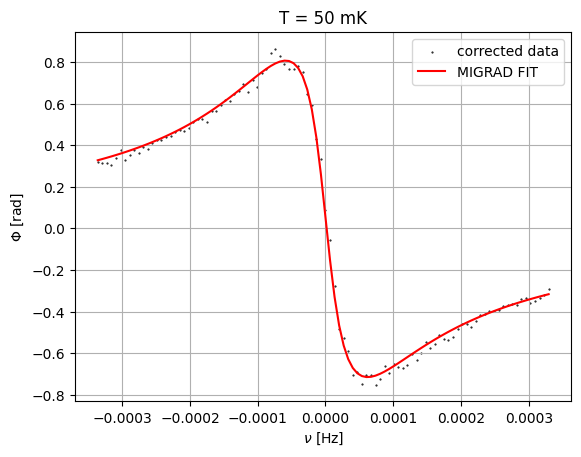

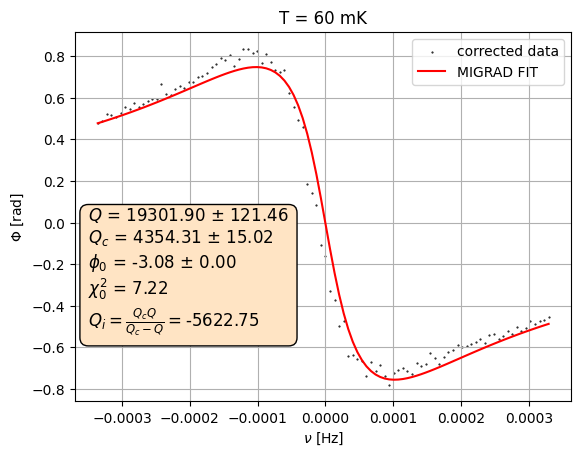

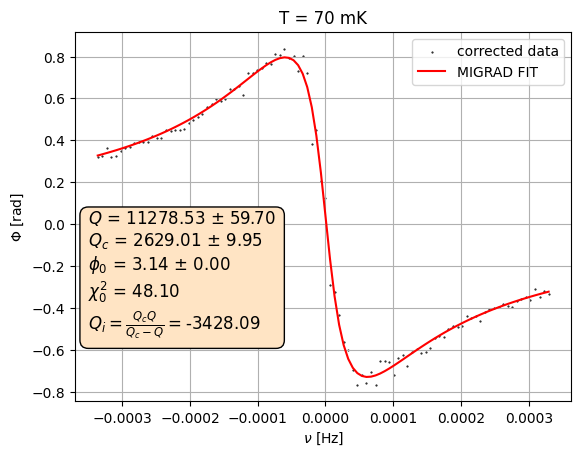

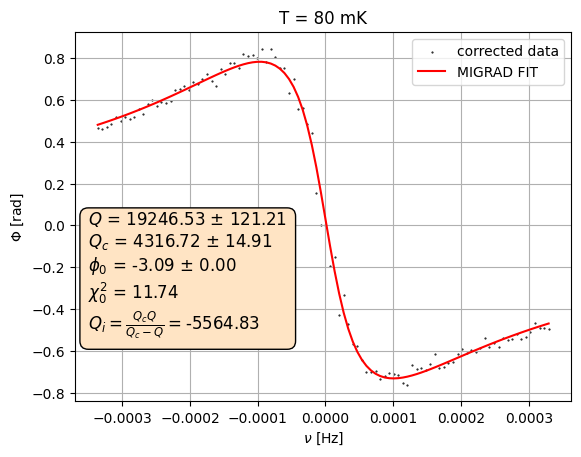

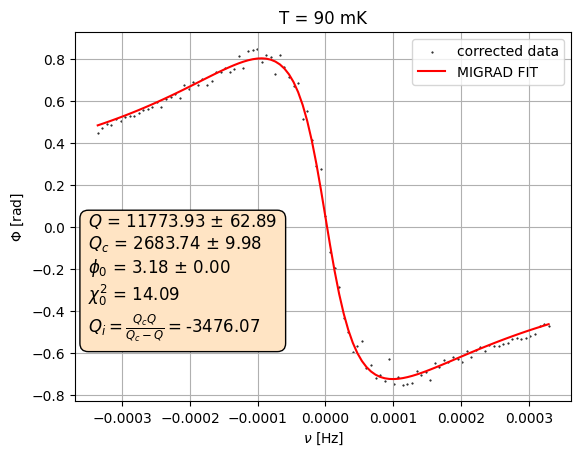

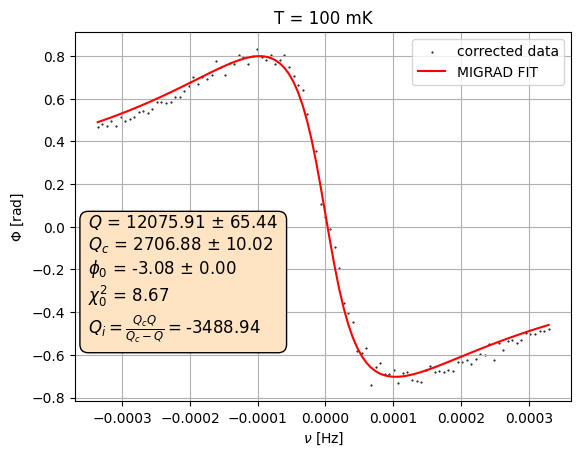

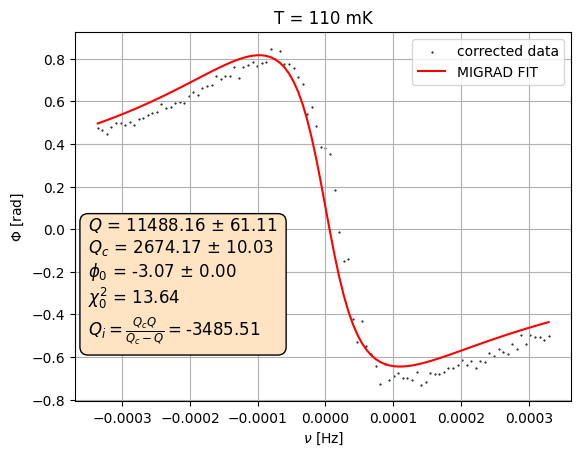

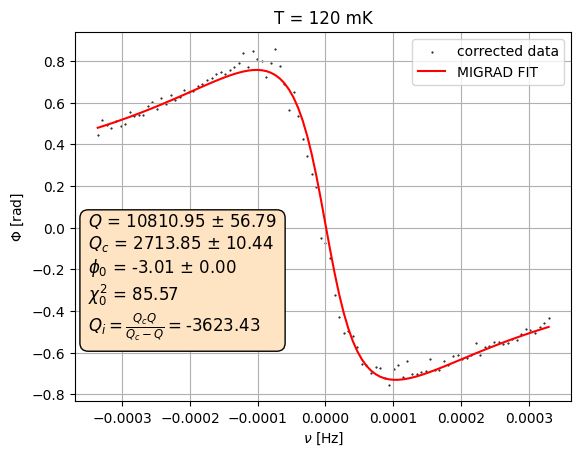

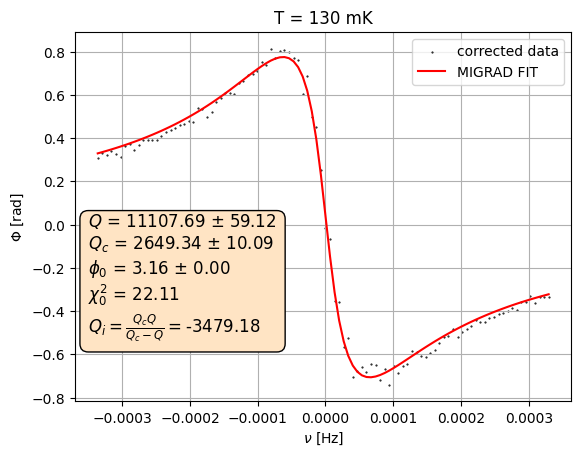

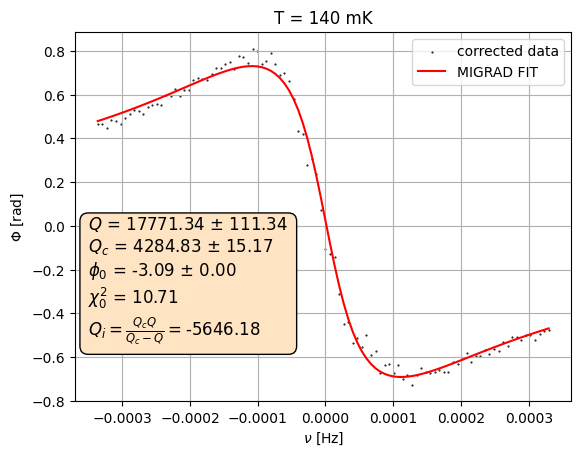

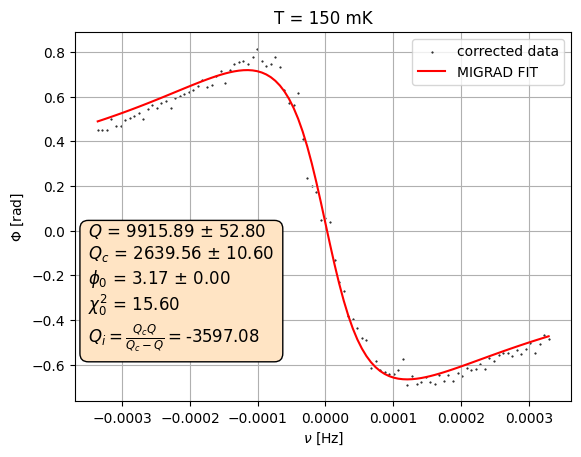

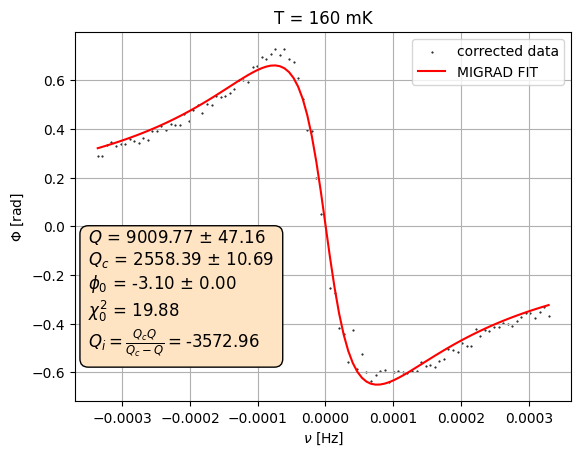

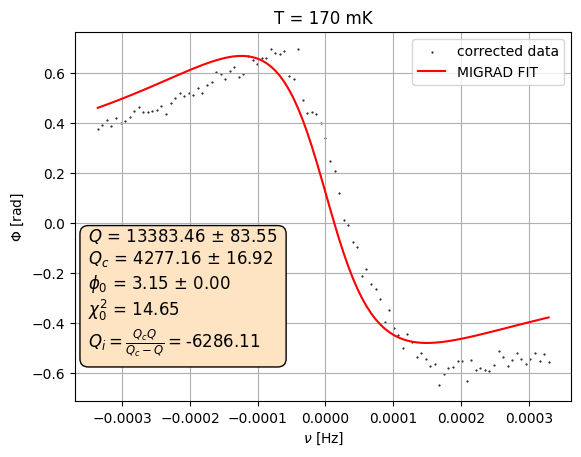

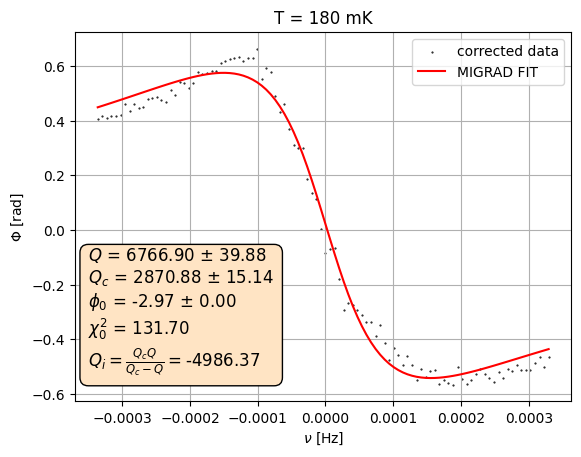

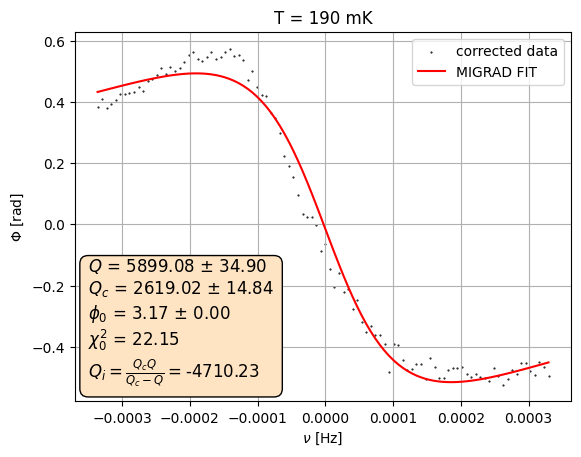

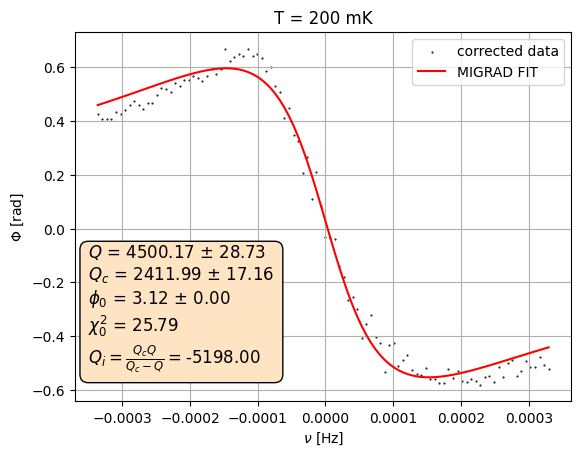

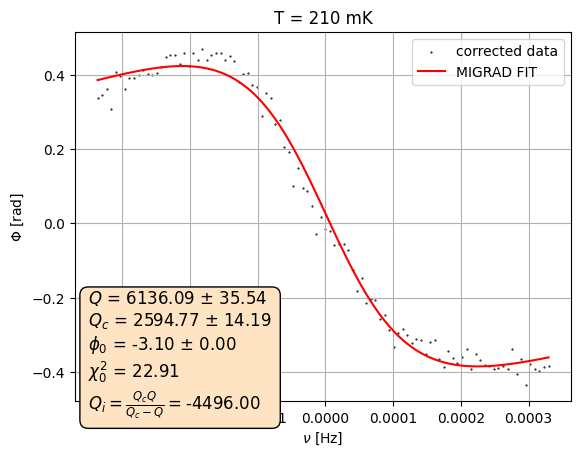

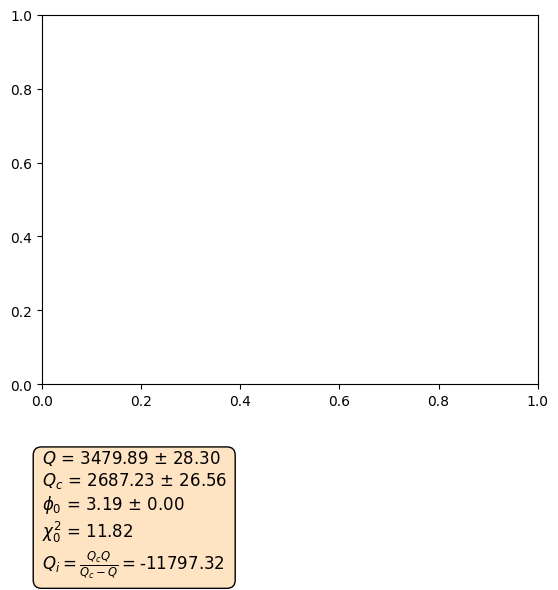

In [12]:
for i,t in enumerate(T):
    plt.scatter(F[i],Phi[i],label='corrected data',color='black',marker='.',s=1)
    plt.xlabel(r'$\nu$ [Hz]')
    plt.ylabel(r'$\Phi$ [rad]')
    plt.plot(F[i],phase(F[i],*m[i].values),label='MIGRAD FIT',color='red')
    plt.legend()
    plt.grid()
    plt.title('T = '+str(t)+' mK')
    plt.show()
    box_props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='bisque')
    text_box_content = (r'$Q$ = '+f'{m[i].values[0]:.2f}'+r' $\pm$ '+f'{m[i].errors[0]:.2f}\n' +
                        r'$Q_{c}$ = '+f'{m[i].values[1]:.2f}'+r' $\pm$ '+f'{m[i].errors[1]:.2f}\n' +
                        r'$\phi_{0}$ = '+f'{m[i].values[2]:.2f}'+r' $\pm$ '+f'{m[i].errors[2]:.2f}\n'+
                        r'$\chi^{2}_{0}$ = '+ f'{(m[i].fval/m[i].ndof):.2f}\n'+
                        r'$Q_{i} = \frac{Q_{c}Q}{Q_{c}-Q} = $'+f'{(1/m[i].values[0]-1/m[i].values[1])**(-1):.2f}')
    text_box = plt.text(-0.00035, -0.5, text_box_content, fontsize=12, color='black', bbox=box_props)

In [16]:
y, yerr = [], []
with open('Results.txt', 'w') as file:
    file.write('T\tQ\tsigma_Q\tQc\tsigma_Qc\n')
    for i, obj in enumerate(m):
        T_val = int(T[i])
        Q_val = float(m[i].values[0])
        sigma_Q_val = float(m[i].errors[0])
        Qc_val = float(m[i].values[1])
        sigma_Qc_val = float(m[i].errors[1])
        Qi_val = pow((1/m[i].values[0]-1/m[i].values[1]),-1)
        y.append(1/Qi_val)
        sigma_Qi_val = m[i].errors[1]/(m[i].values[1]**2)+m[i].errors[2]/(m[i].values[2]**2) 
        yerr.append(sigma_Qi_val)
        file.write(f'{T_val}\t{Q_val}\t{sigma_Q_val}\t{Qc_val}\t{sigma_Qc_val}\n')


In [24]:
x = np.array([t for t in T if t not in [50,70,130,160]])*1e-3
yerr = np.array([yerr[i] for i,t in enumerate(T) if t not in [50,70,130,160]]) 
xerr = 0.001
y = np.array([y[i] for i,t in enumerate(T) if t not in [50,70,130,160]])

In [25]:
from scipy import constants as cnst

In [26]:
alpha = 0.8669
d0 = 1.69*1e-23
hbar = cnst.Planck
KB = cnst.Boltzmann
b = 8e-5
T_k = 0.15
q0 = y[0]
p = [d0, b, T_k]

In [27]:
from scipy import special as sp

def kondo(T,d0, b, T_k):
    omega = 5*1e9
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + q0 - b*np.log10(T/T_k)

In [28]:
LSQ = (LeastSquares(x,y,0.00001,kondo))
mom = (minuit.Minuit(LSQ,*p))
mom.migrad()

C:\Users\ricca\AppData\Local\Temp\ipykernel_17892\480904452.py:6: RuntimeWarning: overflow encountered in exp
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\ricca\AppData\Local\Temp\ipykernel_17892\480904452.py:7: RuntimeWarning: overflow encountered in exp
  den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
C:\Users\ricca\AppData\Local\Temp\ipykernel_17892\480904452.py:8: RuntimeWarning: invalid value encountered in divide
  return num/den * (alpha/2) + q0 - b*np.log10(T/T_k)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 91.11 (χ²/ndof = 9.1)      │              Nfcn = 172              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ d0   │ 1.69e-23  │    nan    │            │            │         │         │       │
│ 1 │ b    │   8e-5    │    nan    │            │            │         │         │       │
│ 2 │ T_k  │  1.5e-1   │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────┐
│     │  d0   b T_k │
├─────┼─────────────┤
│  d0 │ nan nan nan │
│   b │ nan nan nan │
│ T_k │ nan nan nan │
└─────┴─────────────┘

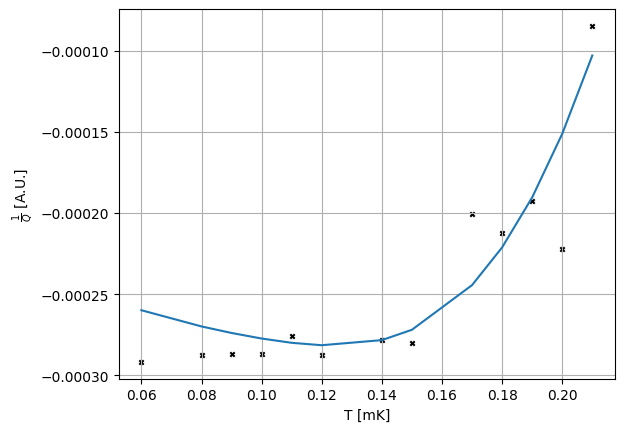

In [29]:
plt.scatter(x,y,s=10,color='black',marker='x')
plt.plot(x,kondo(x, *p))
plt.ylabel(r'$\frac{1}{Q}$ [A.U.]')
plt.xlabel('T [mK]')
plt.grid()